In this notebook, I look at how gamma behaves with the choice of temporal weights matrix and neighbours identification method, in order to choose the appropriate methods for subsequent analysis.

I also do a simulation study to give an intuition of how gamma behaves with the temporal profile.

# Staging

In [1]:
import pandas as pd
import geopandas as gpd
import seaborn as sns
import warnings
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import pacf, kpss, adfuller
from statsmodels.graphics.tsaplots import plot_acf
from scipy.optimize import fsolve
from scipy import stats
import random as rd
from numpy import random
import contextily as cx

In [2]:
# Time series data
stn_ts_throughput = pd.read_csv('outputs/stn_data/demand/stn_ts_throughput.csv',
                                index_col='StationName')

agg_ts_throughput = pd.read_csv('outputs/stn_data/demand/agg_ts_throughput.csv')

In [3]:
# Import operating hours mapper
df_time = pd.read_csv('outputs/stn_data/others/operating_hours.csv')

# Labels of slots
slots_plot = df_time['entrytime_start']

In [4]:
sns.set(style="darkgrid")

# Behaviour of Gamma

I will first check how gamma behaves when the demand profile exhibits a random distribution, then the range of gamma for the throughput of all stations.

## Create functions and set parameters for scalability

In [5]:
# Create function to transform data to make time series stationary

def transform_data(df, transform_mtd, p_threshold, diff_threshold):

    '''
    Make a time series stationary using various data transformation.
    For time series data to be considered stationary:
    Null hypothesis of ADF should be rejected, i.e. p-value < 0.05
    Null hypothesis of KPSS should not be rejected, i.e. p-value > 0.05
    
    :param df: the time series data
    :param transform_mtd: method to transform time series;
    :                     options: ['difference', 'log_transform', 'box_cox']
    :param p_threshold: threshold p-vale
    :param diff_threshold: threshold value to terminate differencing if
    :                      non-stationary;
    :                      applicable for 'difference' only
    :return: the order of differencing/whether stationary or not
    :        transformed time series data,
    :        and Box-Cox lambda
    '''

    # --- DIFFERENCING METHOD --- #

    if transform_mtd == 'difference':
        # Set arbitrary starting p-value for both tests
        # To continue testing and difference if p_adf > 0.05 or p_kpss < 0.05,
        # and order of differencing is less than threshold value
        p_adf = 1
        p_kpss = 0

        # Initialize variable to hold order of difference
        stat_status = -1

        # While data is not stationary (i.e. p_adf > 0.05 or p_kpss < 0.05)
        while p_adf > p_threshold or p_kpss < p_threshold:

            stat_status += 1

            # Difference data (unless this is the first round of tests, 
            # in which case we use the original data)
            if stat_status != 0:
                df_stat = df.diff(periods=stat_status)[stat_status:]
            else:
                df_stat = df.copy()

            # Find p-value of both test
            p_adf = adfuller(df_stat)[1]
            p_kpss = kpss(df_stat)[1]

            # Break out of loop if data is still not stationary by
            # the threshold value of differencing
            if stat_status == diff_threshold:
                break

        bc_lambda = 'N.A'

    # --- LOG-TRANSFORM OR BOX-COX METHOD --- #

    if transform_mtd == 'log_transform' or transform_mtd == 'box_cox':

        df_stat = df.copy()

        # Apply small offset for values of zero
        df_stat = df_stat.apply(lambda x: 0.0000000001
                                if x.values[0] == 0
                                else x.values[0], axis=1)

        # Transform data
        if transform_mtd == 'log_transform':
            df_stat = np.log10(df_stat)
            bc_lambda = 'N.A'
        else:
            df_stat, bc_lambda = stats.boxcox(df_stat)

        # Compute p-values
        p_adf = adfuller(df_stat)[1]
        p_kpss = kpss(df_stat)[1]

        # Return whether data is stationary
        if p_adf < p_threshold and p_kpss > p_threshold:
            stat_status = 'Stationary'
        else:
            stat_status = 'Not stationary'

    return stat_status, df_stat, bc_lambda

In [6]:
# Create function to compute order of AR(p) process

def order_ar(df):

    '''
    Find the order p of AR(p) process by finding when 
    PACF falls within +/- 95% CI (1.96/sqrt(T))

    :param df: the time series data
    :return: the order p of AR(p) process
    '''

    # Compute PACF
    Pacf = pacf(df, nlags=round(len(df)/4), method='ols')

    # Compute CI
    ci = 1.96/np.sqrt(len(df))

    # Find lag which falls within CI, and the order
    lag = np.where(np.logical_and(Pacf>=-ci, Pacf<=ci))[0][0]
    ord_ar = lag-1

    return ord_ar

In [7]:
# Create function to generate equation to tune alpha

def func(x, wt_list, wt_sum):

    '''
    Generate the callable equation to tune alpha for either
    simple exponential smoohting or negative power weighting method
    using fsolve function in scipy.

    :param x: variable for alpha
    :param wt_list: list of weights
    :param wt_sum: sum of weights
    :return: Callable function
    '''

    # Generate eqn
    eqn = ' + '.join(wt_list) + wt_sum

    return eval(eqn)

In [8]:
# Create function to generate temporal weight matrix

def temporal_wt_matrix(df, n_nb, wt_mtd):

    '''
    Compute the temporal weight matrix for a time series,
    based on the number of neighbours and weight assignment method
    chosen by user.

    :param df: the time series data
    :param n_nb: number of neighbours
    :param wt_mth: method to assigning weights; ['indicator', 'ses', 'neg_pow' or 'neg_exp']
    :return: list of temporally lagged values
    '''

    # Need to import math here again because of 
    # issues with using 'eval' in local scope
    import math

    # Initialize dataframe to hold temporal weight matrix
    wt_matrix = {}

    # Get length of time series,
    # check whether length is odd or even, 
    # and get midpoint
    T = len(df)
    odd_even = T%2   # odd if 1, even if 0
    if odd_even == 1:
        midpoint = math.ceil(T/2)
    else:
        midpoint = math.floor(T/2)

    # Get slot names
    slot_idx = df.index

    # Set sum of weights and del_t
    if wt_mtd == 'indicator':
        wt_sum = -1
        del_t = None
    if wt_mtd == 'ses':
        wt_sum = -0.999
        del_t = None
    if wt_mtd == 'neg_pow' or wt_mtd == 'neg_exp':
        wt_sum = -1
        del_t = 15

    # Solve for value of alpha first
    if wt_mtd == 'indicator':
        base_eqn = ['x' for j in range(T)]
    if wt_mtd == 'ses':
        base_eqn = ['x*(1-x)**'+str(j) for j in range(T)]
    if wt_mtd == 'neg_pow':
        base_eqn = ['(' + str(j+1) + '*' + str(del_t) + ')**(-x)'
                    for j in range(T)]
    if wt_mtd == 'neg_exp':
        base_eqn = ['math.exp(-x*' + str(j+1) + '*' + str(del_t) + ')'
                    for j in range(T)]

    x = fsolve(func, [wt_sum/T],
               args=(base_eqn, str(wt_sum)))[0]

    # For observations of interest i up to mid-point
    for i in range(1, midpoint+1):

        # Get number of weights on the right
        last_wt = min(n_nb, T-i)

        # Generate right half of weights
        if wt_mtd == 'indicator':
            right_wt = ['x' for j in range(last_wt)]
        if wt_mtd == 'ses':
            right_wt = ['x*(1-x)**'+str(j) for j in range(last_wt)]
        if wt_mtd == 'neg_pow':
            right_wt = ['(' + str(j+1) + '*' + str(del_t) + ')**(-x)'
                        for j in range(last_wt)]
        if wt_mtd == 'neg_exp':
            right_wt = ['math.exp(-x*' + str(j+1) + '*' + str(del_t) + ')'
                        for j in range(last_wt)]

        # Add trailing zeros in right half of weight list
        right_wt = right_wt + ['0']*(T-i-n_nb)

        # Generate entire weight list
        wt_matrix[slot_idx[i-1]] = right_wt[0:i-1][::-1] + ['0'] + right_wt

    # Compute weights
    scope = locals()
    for k, v in wt_matrix.items():
        wt_list = [eval(j, scope) for j in v]
        if n_nb != 0:
            wt_matrix[k] = [j/sum(wt_list) for j in wt_list]
        else:
            wt_matrix[k] = wt_list

    # For remaining observations of interest i
    for i in range(midpoint+1, T+1):
        # Get 'index' of mirror observation
        mirror = (T-i)+1
        wt_matrix[slot_idx[i-1]] = wt_matrix[slot_idx[mirror-1]][::-1]

    return wt_matrix

In [9]:
# Create function to compute temporally lagged values

def temporal_lagged(df, wt_matrix):

    '''
    Compute the temporally lagged values for a time series.

    :param df: the time series data
    :param wt_matrix: dictionary of weight matrix
    :return: list of temporally lagged values
    '''

    # Compute temporally lagged variable
    temp_lagged = [sum(df['Y']*wt_matrix[slot]) for slot in df.index]

    return temp_lagged

In [10]:
# Create function to compute Gini

def gini(df, var_type):

    '''
    Compute the Gini index for the entries. 
    Works for both original time series data and temporally lagged data

    :param df: the time series data
    :param var_type: whether it is for original values or temporally lagged values, ['Y', 'WY']
    :return: Gini index
    '''

    # Sort time slot in ascending order by value
    df_sorted = df.sort_values(var_type)

    # Add a column on the cumulative distribution function of rank, F
    n_slots = len(df_sorted)
    df_sorted['F'] = np.array(range(1, n_slots+1)) / n_slots

    # Compute Gini index
    covar = df_sorted.cov().loc['Y', 'F']
    gini_stn = 2*covar/df_sorted['Y'].mean()

    return gini_stn

In [11]:
# Create function to perform one run of Monte Carlo simulation

def mc_sim(wt_mtds, nb_mtds, n_sim, tot_demand, n_slots, diff_param):

    '''
    Perform one run of Monte Carlo to get value of Gini and gamma

    :param wt_mtds: weight methods
    :param nb_mtds: neighbour methods
    :param n_sim: number of simulations in a run
    :param tot_demand: total demand
    :param n_slots: number of timeslots
    :param diff_param: parameters for differencing [transform_mtd, p_threshold, diff_threshold]
    :return df_gini_sim: df of Gini in all simulations for each combination
    :return df_gamma_sim: df of Gini in all simulations for each combination
    :return df_med: df of median values for Gini and Gamma
    '''

    # Create lists to hold median values
    gini_med = []
    gamma_med = []
    wt_mtd_list = []
    nb_mtd_list = []

    # Columns headers
    col_head = ['sim_' + str(n) for n in range(n_sim)]

    # All timeslots
    timslots = set(range(1, n_slots+1))

    # For each weight methods:
    for wt_mtd in wt_mtds:

        # Create dictionary of weight matrix that will be added on iteratively.
        # This will save computational effort. Note this is possible because
        # the weights matrix does not depend on which station's data is used.
        wt_matrix_dict = {}

        # For each neighbour method
        for nb_mtd in nb_mtds:

            # Create list to hold Gini and Gamma from simulations
            gini_sim = []
            gamma_sim = []

            # For each simulation
            for run in range(n_sim):

                # Generate when demand occurs
                rand_slot = rd.choices(range(1, n_slots+1), k=tot_demand)

                # Count values
                values, counts = np.unique(rand_slot, return_counts=True)

                # Find timeslots with no demand and add back
                slot_null = timslots-set(values)
                values = list(values) + list(slot_null)
                counts = list(counts) + [0]*len(slot_null)

                # Compute Gini
                ts_rand = pd.DataFrame(counts, columns=['Y'])
                G = gini(ts_rand, 'Y')
                gini_sim.append(G)

                # Get order of station depending on method
                if nb_mtd == 0:
                    ord_diff_stn, ts_stat, _ = \
                        transform_data(ts_rand,
                                       transform_mtd=diff_param[0],
                                       p_threshold=diff_param[1],
                                       diff_threshold=diff_param[2])
                    ord_ar_stn = order_ar(ts_stat)
                elif nb_mtd in nb_mtds[1:-1]:
                    ord_ar_stn = nb_mtd
                elif nb_mtd == nb_mtds[-1]:
                    ord_ar_stn = n_slots

                # Get weight matrix
                if ord_ar_stn not in wt_matrix_dict.keys():
                    wt_matrix = temporal_wt_matrix(ts_rand.copy(),
                                                   ord_ar_stn,
                                                   wt_mtd=wt_mtd)
                    wt_matrix_dict[ord_ar_stn] = wt_matrix
                else:
                    wt_matrix = wt_matrix_dict[ord_ar_stn]

                # Compute temporally lagged values and temporally re-ranked Gini
                if ord_ar_stn == 0:
                    G_T = 0
                else:
                    ts_rand['WY'] = temporal_lagged(ts_rand.copy(), wt_matrix)
                    G_T = gini(ts_rand, 'WY')

                # Compute gamma
                gamma_sim.append(G_T/G)

            # Create/append dataframe to hold simulation results
            idx = wt_mtd+'_'+str(nb_mtd)
            df_gini_temp = pd.DataFrame([gini_sim],
                                        columns=col_head,
                                        index=[idx])
            df_gamma_temp = pd.DataFrame([gamma_sim],
                                         columns=col_head,
                                         index=[idx])
            if (wt_mtd == wt_mtds[0]) and (nb_mtd == nb_mtds[0]):
                df_gini_sim = df_gini_temp.copy()
                df_gamma_sim = df_gamma_temp.copy()
            else:
                df_gini_sim = pd.concat([df_gini_sim, df_gini_temp])
                df_gamma_sim = pd.concat([df_gamma_sim, df_gamma_temp])

            # Compute median gini and gamma
            gini_med.append(np.median(df_gini_temp))
            gamma_med.append(np.median(df_gamma_temp))
            wt_mtd_list.append(wt_mtd)
            nb_mtd_list.append(nb_mtd)

    # Create dataframe of median gini and gamma values
    df_med = pd.DataFrame(zip(wt_mtd_list, nb_mtd_list, gini_med, gamma_med),
                          columns=['wt_mtd', 'nb_mtd', 'Gini', 'Gamma'])

    return df_gini_sim, df_gamma_sim, df_med

In [12]:
# Weight assignment methods
wt_mtds = ['indicator', 'ses', 'neg_pow', 'neg_exp']
wt_map = {wt_mtds[0]: 'Indicator',
          wt_mtds[1]: 'Simple Exponential',
          wt_mtds[2]: 'Negative Power',
          wt_mtds[3]: 'Negative Exponential'}

# Neighbours identification method
max_ord = 6
nb_mtds = range(max_ord+2)   # +1 for order of indiv stn, +1 for all obs

# Mapping for neighbours identification
nb_map = {0: 'h = p'}
for i in nb_mtds[1:-1]:
    nb_map[i] = 'h = '+str(i)
nb_map[nb_mtds[-1]] = 'h = T'
nb_map

{0: 'h = p',
 1: 'h = 1',
 2: 'h = 2',
 3: 'h = 3',
 4: 'h = 4',
 5: 'h = 5',
 6: 'h = 6',
 7: 'h = T'}

In [13]:
# Data transformation method
transform_mtd = 'difference'

# Threshold values for differencing
p_threshold = 0.05
diff_threshold = 40

diff_param = [transform_mtd, p_threshold, diff_threshold]

In [14]:
# Number of simulations in each run
n_sim = 100

# Number of runs
n_run = 100

# Number of slots
n_slots = len(stn_ts_throughput.columns)

In [15]:
# Set color palette
col_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Gamma under randomization

To generate the number of journeys in each time interval, I used an uniform distribution such that the total demand is equal to the average daily demand of a station.

### Prepare uniform distribution

In [16]:
# Get total demand in a day
tot_demand = int(sum(agg_ts_throughput['NumberOfJourneys'])/
                 len(stn_ts_throughput))

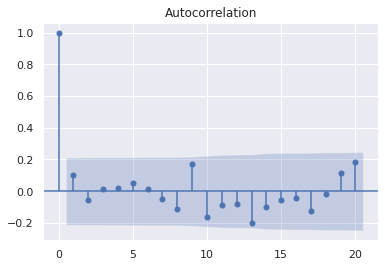

In [17]:
# Run one simulation and confirm no autocorrelation
rand_slot = rd.choices(range(1, n_slots+1), k=tot_demand)

# Count values
values, counts = np.unique(rand_slot, return_counts=True)

# Find timeslots with no demand and add back
slot_null = set(range(1, n_slots+1))-set(values)
values = list(values) + list(slot_null)
counts = list(counts) + [0]*len(slot_null)

plot_acf(np.array(counts));

### Run simulations

In [18]:
# Note: All the simulation results reported in the dissertation have been uploaded on the output folders

# Ignore runtime warning
warnings.simplefilter("ignore")

# Run simulations
for run in range(n_run):

    print(f'Run {run}')
    #df_gini_sim_run, df_gamma_sim_run, df_med_run =\
    #    mc_sim(wt_mtds, nb_mtds, n_sim, tot_demand, n_slots, diff_param)
    #df_gini_sim_run.to_csv('outputs/mc_sim/gini_sim_'+str(run)+'.csv')
    #df_gamma_sim_run.to_csv('outputs/mc_sim/gamma_sim_'+str(run)+'.csv')
    #df_med_run.to_csv('outputs/mc_sim/med_sim_'+str(run)+'.csv', index=False)

print('Done!')

# Reset warnings
warnings.resetwarnings()

Run 0
Run 1
Run 2
Run 3
Run 4
Run 5
Run 6
Run 7
Run 8
Run 9
Run 10
Run 11
Run 12
Run 13
Run 14
Run 15
Run 16
Run 17
Run 18
Run 19
Run 20
Run 21
Run 22
Run 23
Run 24
Run 25
Run 26
Run 27
Run 28
Run 29
Run 30
Run 31
Run 32
Run 33
Run 34
Run 35
Run 36
Run 37
Run 38
Run 39
Run 40
Run 41
Run 42
Run 43
Run 44
Run 45
Run 46
Run 47
Run 48
Run 49
Run 50
Run 51
Run 52
Run 53
Run 54
Run 55
Run 56
Run 57
Run 58
Run 59
Run 60
Run 61
Run 62
Run 63
Run 64
Run 65
Run 66
Run 67
Run 68
Run 69
Run 70
Run 71
Run 72
Run 73
Run 74
Run 75
Run 76
Run 77
Run 78
Run 79
Run 80
Run 81
Run 82
Run 83
Run 84
Run 85
Run 86
Run 87
Run 88
Run 89
Run 90
Run 91
Run 92
Run 93
Run 94
Run 95
Run 96
Run 97
Run 98
Run 99
Done!


In [19]:
# Retrieve all gamma values from simulations
for run in range(n_run):
    df_gamma_temp = pd.read_csv('outputs/mc_sim/gamma_sim_'+str(run)+'.csv')
    df_gamma_temp.rename({'Unnamed: 0': 'combi'},
                         axis=1, inplace=True)
    df_gamma_temp.set_index('combi', inplace=True)
    if run == 0:
        df_gamma = df_gamma_temp.copy()
    else:
        df_gamma = pd.concat([df_gamma, df_gamma_temp], axis=1)

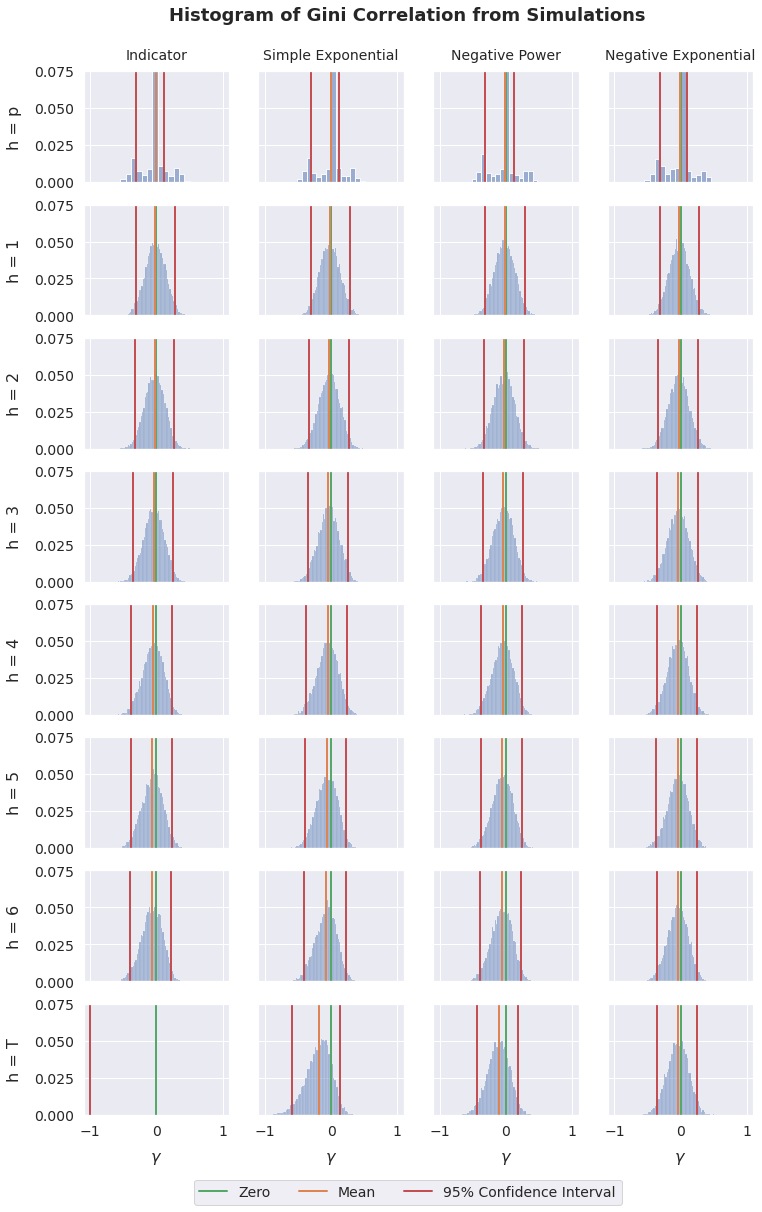

In [20]:
# Plot histogram
fig, ax = plt.subplots(len(nb_mtds), len(wt_mtds), figsize=(12, 18),
                       sharex='col', sharey='row')

for x in range(len(wt_mtds)):
    for y in range(len(nb_mtds)):

        wt_mtd = wt_mtds[x]
        nb_mtd = nb_mtds[y]

        # Get data
        data_plot = df_gamma[df_gamma.index == (str(wt_mtd)+'_'+str(nb_mtd))]

        # Get mean and CI
        lb = np.percentile(data_plot, 2.5)
        ave = np.mean(data_plot, axis=1)[0]
        ub = np.percentile(data_plot, 97.5)

        # Plot
        sns.histplot(data=data_plot.T, ax=ax[y, x],
                     stat='probability', legend=False)
        zero_line = ax[y, x].axvline(x=0, color=col_pal[2], linewidth=2)
        ave_line = ax[y, x].axvline(x=ave, color=col_pal[1], linewidth=2)
        ub_line = ax[y, x].axvline(x=ub, color=col_pal[3], linewidth=2)
        lb_line = ax[y, x].axvline(x=lb, color=col_pal[3], linewidth=2)
        
        # Styling
        ax[y, x].set(xlabel=None, xlim=[-1.1, 1.1], 
                     yticks=np.arange(0, 0.1, 0.025), ylim=[0, 0.075])
        ax[y, x].set_ylabel(nb_map[nb_mtd], fontsize=16, labelpad=12)
        ax[y, x].set_xlabel(r"$\gamma$", fontsize=16, labelpad=12)
        ax[y, x].tick_params(labelsize=14)

    ax[0, x].set_title(wt_map[wt_mtd], fontsize=14, pad=12)

fig.legend((zero_line, ave_line, ub_line),
           ('Zero', 'Mean', '95% Confidence Interval'),
           loc='lower center', ncol=3, fontsize=14, 
           bbox_to_anchor=(0.5, 0.05))

fig.suptitle("Histogram of Gini Correlation from Simulations", size=18, weight='bold')
plt.subplots_adjust(top=0.93)

#fig.savefig('outputs/figures/measure_development/gamma_random_hist.png',
#            bbox_inches="tight")

## Range of Gamma for Stations

I will now check the range of gamma for all stations.

### Compute Gini and order of all stations first

Gini, order of difference and order of AR process of stations will be the same, regardless of the weight assignment and neighbour identifications methods. So we can compute these first.

In [21]:
# Initialize lists to values of individual stations

G = []    # Gini

ord_diff = []    # Order of difference
ord_ar = []    # Order of AR

In [22]:
# Ignore runtime warning
warnings.simplefilter("ignore")

# Compute Gini and order of all stations individually first
for stn in stn_ts_throughput.index:

    # Get time series of station
    ts_stn = stn_ts_throughput.loc[stn_ts_throughput.index == stn].T
    ts_stn.columns = ['Y']

    # Compute Gini
    G.append(gini(ts_stn, 'Y'))

    # Make time series stationary
    ord_diff_stn, ts_stat, _ = \
        transform_data(ts_stn,
                       transform_mtd=transform_mtd,
                       p_threshold=p_threshold,
                       diff_threshold=diff_threshold)

    # Find order of AR(p)
    ord_ar_stn = order_ar(ts_stat)

    # Append to lists
    ord_diff.append(ord_diff_stn)
    ord_ar.append(ord_ar_stn)

# Reset warnings
warnings.resetwarnings()

print('Done!')

Done!


In [23]:
# Create dataframe for stations orders
stn_order = pd.DataFrame(zip(list(stn_ts_throughput.index), ord_diff, ord_ar),
                         columns=[stn_ts_throughput.index.name, 'OrderDiff', 'OrderAR'])

### Iterate through all combinations of methods

In [24]:
# Ignore runtime warning
warnings.simplefilter("ignore")

# Initialize dictionary to form multi-level dataframe
dict_pd = {}

# ----- FOR EACH WEIGHT MTD ----- #

for wt_mtd in wt_mtds:

    if wt_mtd != wt_mtds[0]:
        print('\n')
    print(f'WEIGHT METHOD: {wt_mtd.upper()}')

    # Create dictionary of weight matrix that will be added on iteratively.
    # This will save computational effort. Note this is possible because
    # the weights matrix does not depend on which station's data is used.
    wt_matrix_dict = {}

    # ----- FOR EACH NEIGHBOUR MTD ----- #

    for nb_mtd in nb_mtds:
        print(f'Neighbour Method: {nb_map[nb_mtd]}')

        # Initialize list to hold values of G_T
        G_T = []

        # ----- FOR EACH STATION ----- #

        for stn in stn_ts_throughput.index:

            # Get time series of station
            ts_stn = stn_ts_throughput.loc[stn_ts_throughput.index == stn].T
            ts_stn.columns = ['Y']

            # Get order of station depending on method
            if nb_mtd == 0:
                ord_ar_stn =\
                    stn_order[stn_order['StationName'] == stn]['OrderAR'].values[0]
            elif nb_mtd in nb_mtds[1:-1]:
                ord_ar_stn = nb_mtd
            elif nb_mtd == nb_mtds[-1]:
                ord_ar_stn = n_slots

            # Get weight matrix
            if ord_ar_stn not in wt_matrix_dict.keys():
                wt_matrix = temporal_wt_matrix(ts_stn.copy(),
                                               ord_ar_stn,
                                               wt_mtd=wt_mtd)
                wt_matrix_dict[ord_ar_stn] = wt_matrix
            else:
                wt_matrix = wt_matrix_dict[ord_ar_stn]

            # Compute temporally lagged values and temporally re-ranked Gini
            if ord_ar_stn == 0:
                G_T.append(0)
            else:
                ts_stn['WY'] = temporal_lagged(ts_stn.copy(), wt_matrix)
                G_T.append(gini(ts_stn, 'WY'))

            # ----- (END) FOR EACH STATION ----- #

        # Compute gamma
        gamma = [G_T_stn/G_stn for G_T_stn, G_stn in zip(G_T, G)]
        
        # Enter into dictionary to form multi-level dataframe
        dict_pd[wt_mtd+'_'+str(nb_mtd)] =\
            pd.DataFrame(zip(list(stn_ts_throughput.index), G, G_T, gamma),
                         columns=[stn_ts_throughput.index.name, 'gini', 'G_T', 'gamma'])

        # ----- (END) FOR EACH NEIGHBOUR MTD ----- #

    # ----- FOR EACH WEIGHT MTD ----- #

# Create multi-level dictionary
stn_gini = pd.concat(dict_pd, axis=1)

# Reset warnings
warnings.resetwarnings()

print('\n')
print('Done!')

WEIGHT METHOD: INDICATOR
Neighbour Method: h = p
Neighbour Method: h = 1
Neighbour Method: h = 2
Neighbour Method: h = 3
Neighbour Method: h = 4
Neighbour Method: h = 5
Neighbour Method: h = 6
Neighbour Method: h = T


WEIGHT METHOD: SES
Neighbour Method: h = p
Neighbour Method: h = 1
Neighbour Method: h = 2
Neighbour Method: h = 3
Neighbour Method: h = 4
Neighbour Method: h = 5
Neighbour Method: h = 6
Neighbour Method: h = T


WEIGHT METHOD: NEG_POW
Neighbour Method: h = p
Neighbour Method: h = 1
Neighbour Method: h = 2
Neighbour Method: h = 3
Neighbour Method: h = 4
Neighbour Method: h = 5
Neighbour Method: h = 6
Neighbour Method: h = T


WEIGHT METHOD: NEG_EXP
Neighbour Method: h = p
Neighbour Method: h = 1
Neighbour Method: h = 2
Neighbour Method: h = 3
Neighbour Method: h = 4
Neighbour Method: h = 5
Neighbour Method: h = 6
Neighbour Method: h = T


Done!


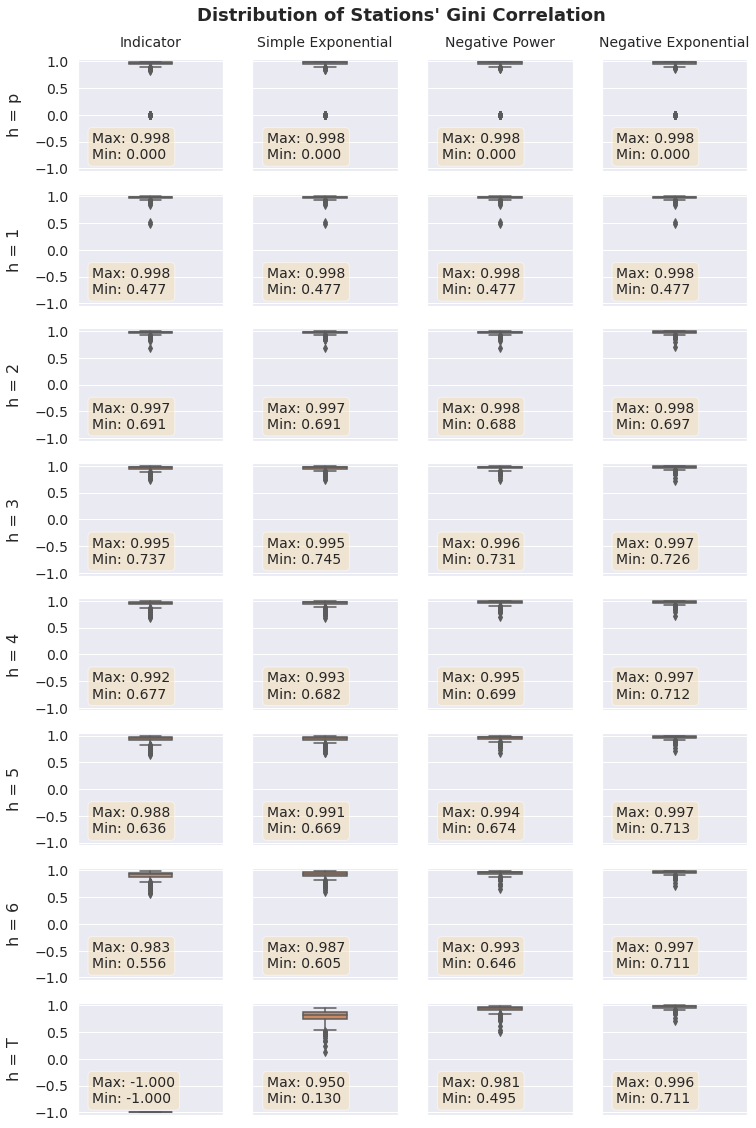

In [25]:
# Plot distribution of gamma

# Ignore runtime warning
warnings.simplefilter("ignore")

fig, ax = plt.subplots(len(nb_mtds), len(wt_mtds), figsize=(12, 18),
                       sharex='col', sharey='row')

for x in range(len(wt_mtds)):
    for y in range(len(nb_mtds)):

        wt_mtd = wt_mtds[x]
        nb_mtd = nb_mtds[y]
        df_col_name = wt_mtd+'_'+str(nb_mtd)

        # Prep dataframe
        df_plot = stn_gini[df_col_name]

        # Plot
        sns.boxplot(data=df_plot, y='gamma',
                    width=0.3, color=col_pal[1], ax=ax[y, x])

        # Formatting
        ax[y, x].tick_params(labelsize=14)
        if x == 0:
            ax[y, x].set_ylabel(nb_map[nb_mtd], fontsize=16, labelpad=12)
        else:
            ax[y, x].set_ylabel('')
        ax[y, x].set(yticks=np.arange(-1, 1.5, 0.5), ylim=[-1.05, 1.05])

        # Textbox
        gamma_min = min(df_plot['gamma'])
        gamma_median = np.percentile(df_plot['gamma'], 50)
        gamma_max = max(df_plot['gamma'])

        textstr = '\n'.join(("Max: "+"{:.3f}".format(gamma_max),
                             "Min: "+"{:.3f}".format(gamma_min)))
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        ax[y, x].text(0.1, 0.35, textstr, transform=ax[y, x].transAxes, fontsize=14,
                      verticalalignment='top', bbox=props)

        ax[y, x].tick_params(labelsize=14)

    ax[0, x].set_title(wt_map[wt_mtd], fontsize=14, pad=12)

fig.suptitle("Distribution of Stations' Gini Correlation", size=18, weight='bold')
plt.subplots_adjust(top=0.94)

# Reset warnings
warnings.resetwarnings()

#fig.savefig('outputs/figures/measure_development/gamma_range.png', bbox_inches="tight")

From the first plot above, we can see that as more observations are considered neighbours, a slight negative bias in the distribution of gamma can be detected. This is because there is likely to be greater variation, hence dissimilarity, in neighbouring values. In accordance with the definition of gamma, gamma therefore decreases. 

From the second plot, we can see that as more observations are considered neighbours, there is an increasing spread in the value of gamma. This is driven by a decrease in the gamma of stations with lower gamma, as stations with higher gamma is less sensitive to the number of neighbours.

Based on the results, it was decided that the temporal weight matrix for stations in this dissertation would be constructred using six time intervals as neighbours (i.e. __h = 6__) and the __indicator function__, since (1) the theoretical value of gamma when the demand profile exhibits a random pattern lies within the 95% confidence interval from the simulations without significant negative bias being introduced, and (2) the range of gamma using actual demand data is sufficiently wide to facilitate comparison between stations.

In [26]:
h = 6
wt_mtd = 'indicator'

In [27]:
# Save files
stn_conc_throughput = stn_gini[wt_mtd+'_'+str(h)]
#stn_conc_throughput.to_csv('outputs/stn_data/concentration/stn_conc_throughput.csv', index=False)

# Distribution of Gini and Gamma

## Distribution and Relationship

In [28]:
# Retrieve concentration data
stn_conc_throughput = pd.read_csv('outputs/stn_data/concentration/stn_conc_throughput.csv')

In [29]:
stn_conc_throughput.describe()

,gini,G_T,gamma
count,265.000000,265.000000,265.000000
mean,0.559414,0.497031,0.897235
std,0.099220,0.068553,0.081296
min,0.365016,0.291832,0.555582
25%,0.482559,0.449028,0.883477
50%,0.542279,0.496530,0.926238
75%,0.612905,0.544303,0.949507
max,0.933102,0.688596,0.983367


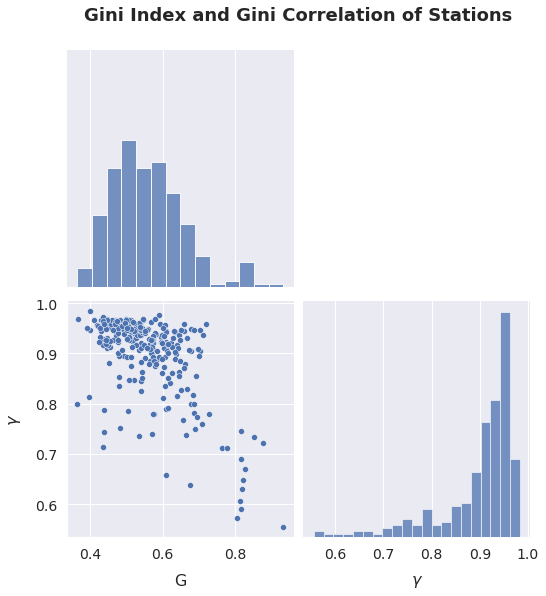

In [30]:
# Plot distribution and relationship of gini and gamma
fig = sns.pairplot(stn_conc_throughput[['gini', 'gamma']], corner='True');
fig.fig.set_size_inches(8,8);
fig.fig.suptitle('Gini Index and Gini Correlation of Stations',
                 fontsize=18, weight='bold', x = 0.55, y=1.05, ha='center');

fig.axes[1, 0].set_xlabel('G', fontsize=16, labelpad=12);
fig.axes[1, 0].set_ylabel(r'$\gamma$', fontsize=16, labelpad=12);
fig.axes[1, 1].set_xlabel(r'$\gamma$', fontsize=16, labelpad=12);

fig.axes[1, 0].tick_params(labelsize=14)
fig.axes[1, 1].tick_params(labelsize=14)

#fig.savefig('outputs/figures/measure_development/gini_gamma_distribution.png',
#            bbox_inches="tight")

Gini and gamma exhibited a weak negative correlation. To understand the reason for this negative correlation, the demand profiles for two stations are plotted. Stations with low G, such as Stratford, are likely to have smoother variation in their demand, which means that there is greater temporal dependence in their demand profile, resulting in a high gamma. On the other hand, stations with high G, such as Chesham, are likely to have sudden spikes in demand, which come across as greater randomness in the demand profile and result in gamma tending towards zero.

In [31]:
# Import operating hours mapper
df_time = pd.read_csv('outputs/stn_data/others/operating_hours.csv')

time_map = {}
time_map_slot = {}
for i in range(len(df_time)):
    time_map[df_time.loc[i, 'timeslot']] = df_time.loc[i, 'entrytime_start']
    time_map_slot['slot_'+str(df_time.loc[i, 'timeslot'])] = df_time.loc[i, 'entrytime_start']

In [32]:
# Time series data
stn_ts_throughput = pd.read_csv('outputs/stn_data/demand/stn_ts_throughput.csv',
                                index_col='StationName')
stn_ts_throughput.columns = df_time['entrytime_start']

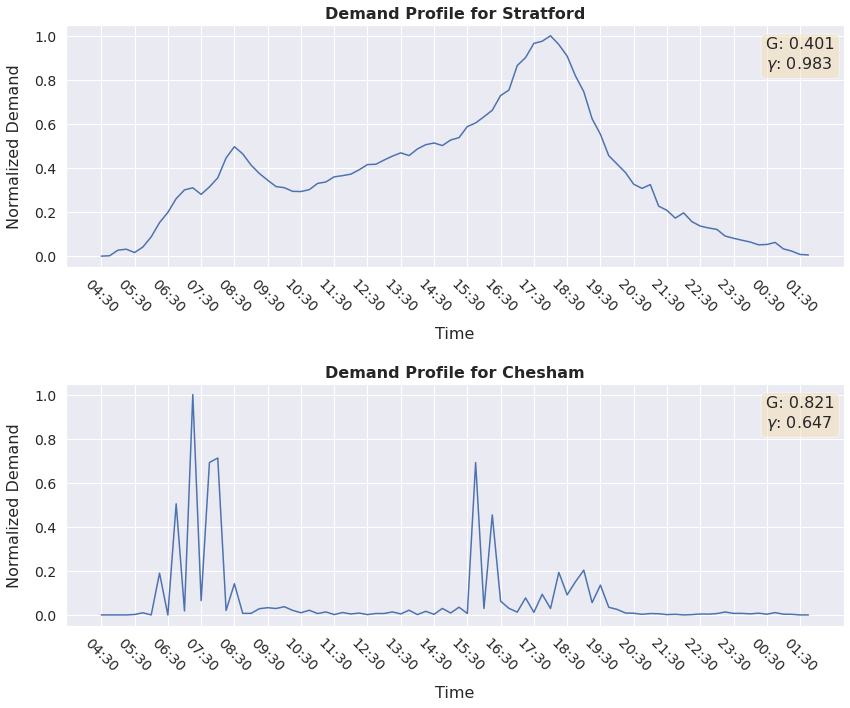

In [33]:
# PLot demand profile
stns = ['Stratford', 'Chesham']

fig, ax = plt.subplots(2, 1, figsize=(12,10))

for i in range(len(stns)):

    # Get stn, normalize demand data and get concentration data
    stn = stns[i]
    demand_data = stn_ts_throughput[stn_ts_throughput.index == stn]
    demand_data = demand_data.subtract(demand_data.min(axis=1), axis=0)\
        .divide(demand_data.max(axis=1) - demand_data.min(axis=1), axis=0)\
        .combine_first(demand_data)
    stn_gini = stn_conc_throughput.loc[stn_conc_throughput['StationName'] == stn, 'gini'].values[0]
    stn_gamma = stn_conc_throughput.loc[stn_conc_throughput['StationName'] == stn, 'gamma'].values[0]

    # Plot demand data
    ax[i].plot(stn_ts_throughput.columns, demand_data.T)
    
    # Styling
    ax[i].set_title(f"Demand Profile for {stn}", fontsize=16, weight='bold')
    ax[i].tick_params(axis='x', rotation=315)
    ax[i].tick_params(labelsize=14)
    ax[i].set_xticks(range(0, 87, 4))
    ax[i].set_xlabel('Time', fontsize=16, labelpad=12)
    ax[i].set_ylabel('Normalized Demand', fontsize=16, labelpad=12)
    
    # Add textbox
    textstr = '\n'.join(("G: "+"{:.3f}".format(stn_gini), 
                         r"$\gamma$: "+"{:.3f}".format(stn_gamma)))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax[i].text(0.9, 0.95, textstr, transform=ax[i].transAxes, fontsize=16,
               verticalalignment='top', bbox=props)

fig.tight_layout()
plt.subplots_adjust(hspace=0.48)

#fig.savefig('outputs/figures/measure_development/stn_comparison.png', bbox_inches="tight")

## Spatial Distribution of Gini and Gamma

For visual inspection of the spatial distribution of gini and gamma, they are mapped out on the network diagram of London Underground.

In [34]:
# Create function for plotting network

def plot_ntw(stn_gdf, line_gdf, plot_crs, measure):

    '''
    Return a plot of the network

    :param stn_gdf: gdf of stations
    :param line_gdf: gdf of lines
    :param plot_crs: crs for plotting
    :param measure: measure being plotted; ['gini', 'gamma']
    :return Moran's plot
    '''

    fig, ax = plt.subplots(figsize=(18,15))
    
    # Plot lines
    line_gdf.plot(ax=ax, linewidth=0.8)

    # Plot stations, depending on what is being plotted
    # Plot gini or gamma
    if measure == 'gini':
        title_label = 'Gini Index'
        leg_label = 'G'
        vmin = 0.3
    if measure == 'gamma':
        title_label = 'Gini Correlation'
        leg_label = r"$\gamma$"
        vmin = 0.5
    # Plot stations
    stn_gdf.plot(column=measure, ax=ax,
                 cmap='OrRd', vmin=vmin, vmax=1.0,
                 legend=True,
                 legend_kwds={'shrink': 0.5,
                              'label': leg_label,
                              'pad': 0.01},
                 markersize=50, edgecolor='grey', linewidth=0.5)
    ax.set_title(f"Spatial Distribution of {title_label}", 
                 fontdict={'fontsize': 12, 'fontweight': 'bold'})

    # Add base map
    cx.add_basemap(ax, crs=plot_crs, source=cx.providers.CartoDB.PositronNoLabels)
    
    # Add north arrow, https://stackoverflow.com/a/58110049/604456
    x, y, arrow_length = 0.9, 0.14, 0.08
    ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
                arrowprops=dict(facecolor='black', width=2, headwidth=6),
                ha='center', va='center', fontsize=10,
                xycoords=ax.transAxes)

    # Add scale-bar
    x, y, scale_len = 546000, 170000, 5000
    scale_rect = matplotlib.patches.Rectangle((x,y),
                                              scale_len,
                                              200, linewidth=1,
                                              edgecolor='k', facecolor='k')
    ax.add_patch(scale_rect)
    plt.text(x+scale_len/2, y+400, s='5 KM',
             fontsize=10, horizontalalignment='center')

    ax.set_axis_off()

    return fig

In [35]:
# Geometry of stations and lines
stations_gdf = gpd.read_file('outputs/stn_data/geometry/stations_gdf.gpkg')
lines_gdf = gpd.read_file('outputs/stn_data/geometry/lines_gdf.gpkg')

bng_crs = stations_gdf.crs

/opt/conda/envs/sds2021/lib/python3.9/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


In [36]:
# Merge concentration date to gdf
stations_gdf = stations_gdf.merge(stn_conc_throughput[['StationName', 'gini', 'gamma']],
                                  left_on='name', right_on='StationName')\
    .drop(columns='StationName')\
    .set_index('name')

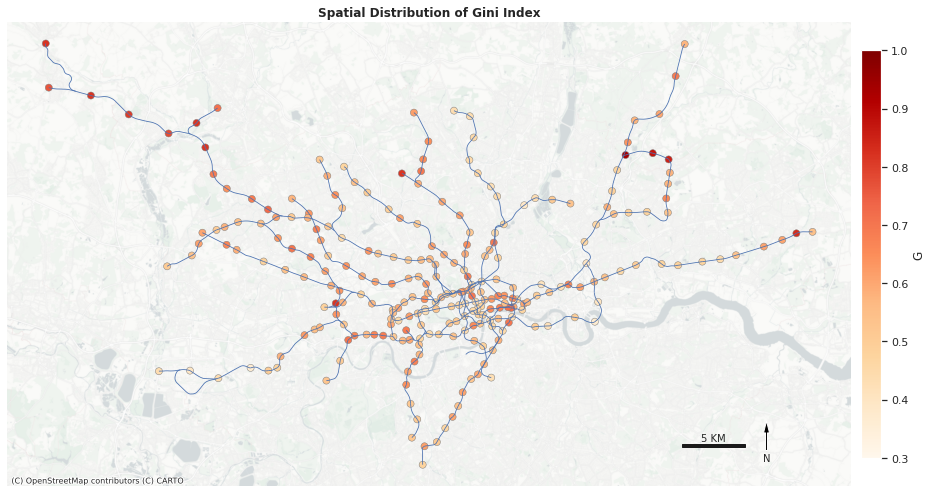

In [37]:
# Gini
fig = plot_ntw(stn_gdf=stations_gdf, line_gdf=lines_gdf,
               plot_crs=bng_crs, measure='gini');

#fig.savefig('outputs/figures/spatial_distribution/ntw_gini.png', bbox_inches="tight")

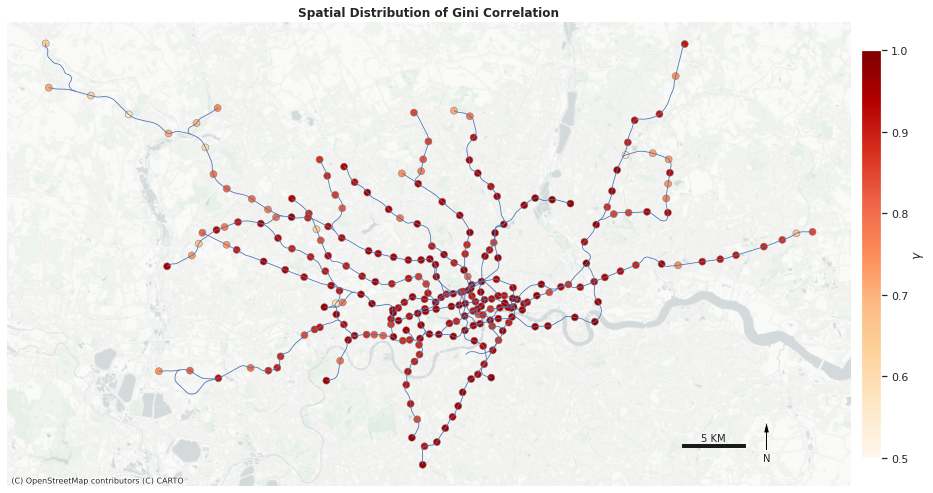

In [38]:
# Gamma
fig = plot_ntw(stn_gdf=stations_gdf, line_gdf=lines_gdf, 
               plot_crs=bng_crs, measure='gamma');

#fig.savefig('outputs/figures/spatial_distribution/ntw_gamma.png', bbox_inches="tight")

# Simulate Changes in Temporal Profile

Here, I simulate what happens to the value of gamma when the temporal profile of journeys change.

## Demonstrate profiles in different range

We will look at three scenarios.
- The first scenario is using the original data itself. This should give a high positive gamma.
- The second scenario is where we permutate the number of journeys randomly. This should give a value of zero.
- The third scenario is to re-arrange the number of journeys such that highs and lows alternate in adjacent timeslots. This should give a high negative gamma.

In [39]:
# Import aggregate data
agg_ts_throughput = pd.read_csv('outputs/stn_data/demand/agg_ts_throughput.csv')

In [40]:
# Scenario 1
sim_1 = agg_ts_throughput.copy()

In [41]:
# Scenario 2
sim_2 = agg_ts_throughput.copy()
np.random.seed(374)
sim_2['NumberOfJourneys'] = np.random.permutation(sim_2['NumberOfJourneys'])

In [42]:
# Scenario 3
sim_3 = agg_ts_throughput.copy()

# Sort number of journeys
sim_3.sort_values(by='NumberOfJourneys', inplace=True)
sim_3.reset_index(drop=True, inplace=True)

# Pick up number of journeys from opposite end of the df
alt_list = []
mid = 43

for i in range(mid):
    alt_list.append(sim_3.loc[i, 'NumberOfJourneys'])
    alt_list.append(sim_3.loc[len(sim_3)-i-1, 'NumberOfJourneys'])

# Add number of journeys back to df
sim_3['NumberOfJourneys'] = alt_list

# Repeat so that similar numbers are farther apart
alt_list = []
mid = 43

for i in range(mid):
    alt_list.append(sim_3.loc[i, 'NumberOfJourneys'])
    alt_list.append(sim_3.loc[len(sim_3)-i-1, 'NumberOfJourneys'])

sim_3['NumberOfJourneys'] = alt_list

# Re-arrange data for similar numbers to be farther apart
cut_1 = 20
cut_2 = 40
cut_3 = 60

sim_3.loc[:, 'NumberOfJourneys'] = \
    list(sim_3.loc[0:cut_1, 'NumberOfJourneys']) +\
    list(sim_3.loc[cut_3+1:, 'NumberOfJourneys']) +\
    list(sim_3.loc[cut_2+1:cut_3, 'NumberOfJourneys']) +\
    list(sim_3.loc[cut_1+1:cut_2, 'NumberOfJourneys'])

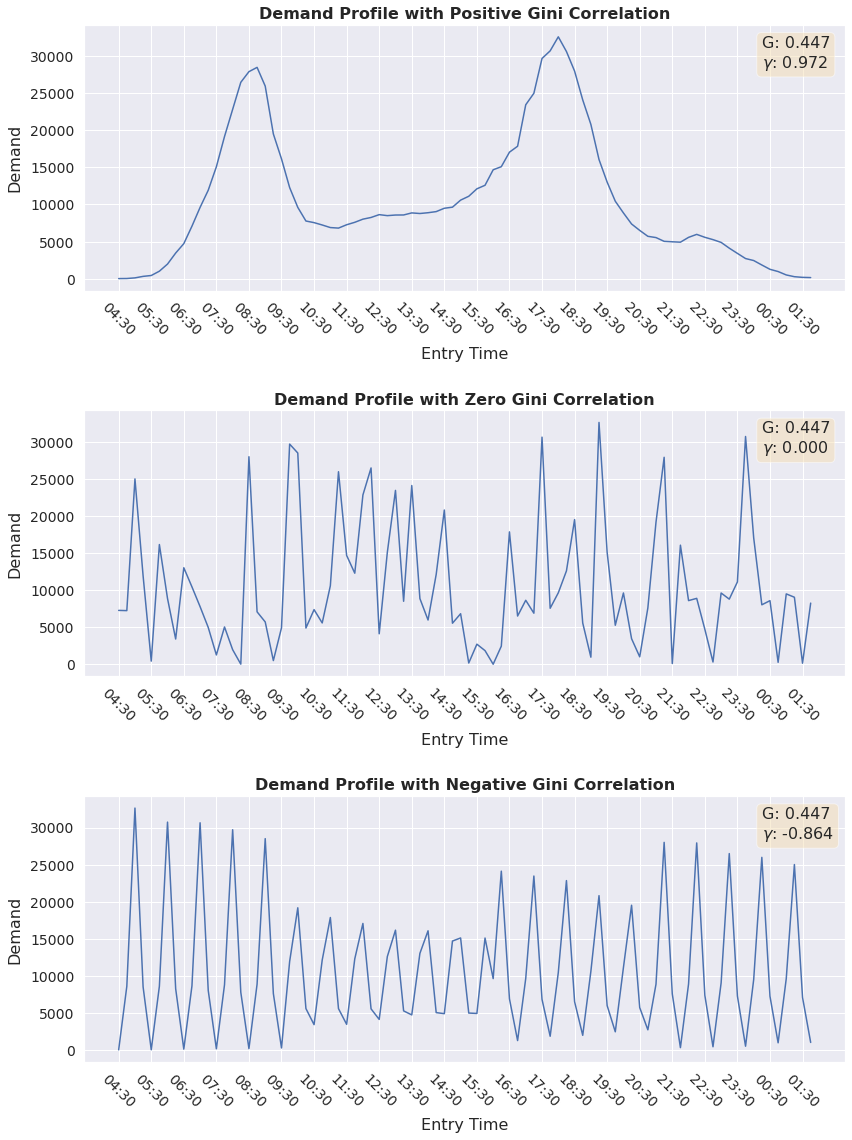

In [43]:
# Set up labels
gamma_label = {0: 'Positive',
               1: 'Zero',
               2: 'Negative'}

# Plot characteristic journey profile
fig, ax = plt.subplots(3, 1, figsize=(12,16))

for i in range(3):

    # Get data
    plot_data = globals()['sim_'+str(i+1)]

    # Compute Gini
    plot_data = plot_data.\
        drop(columns=['Timeslot']).\
        rename({'NumberOfJourneys': 'Y'}, axis=1)
    G = gini(plot_data, 'Y')

    # Compute temporally re-ranked Gini
    wt_matrix = temporal_wt_matrix(plot_data.copy(), 
                                   n_nb=h,
                                   wt_mtd=wt_mtd)

    # Compute temporally lagged values and temporally re-ranked Gini
    plot_data['WY'] = temporal_lagged(plot_data.copy(), wt_matrix)
    G_T = gini(plot_data, 'WY')

    # Compute gamma
    gamma = G_T/G

    # Start to plot
    ax[i].plot(slots_plot, plot_data['Y']);
    ax[i].set_title(f"Demand Profile with {gamma_label[i]} Gini Correlation",
                    fontsize=16, weight='bold')
    ax[i].tick_params(axis='x', rotation=315)
    ax[i].tick_params(labelsize=14)
    ax[i].set_xticks(range(0, 87, 4))
    ax[i].set_xlabel('Entry Time', fontsize=16, labelpad=8)
    ax[i].set_ylabel('Demand', fontsize=16, labelpad=8)
    
    # Add textbox
    textstr = '\n'.join(("G: "+"{:.3f}".format(G), 
                         r"$\gamma$: "+"{:.3f}".format(gamma)))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax[i].text(0.89, 0.96, textstr, transform=ax[i].transAxes, fontsize=16,
               verticalalignment='top', bbox=props)
    
fig.tight_layout()
plt.subplots_adjust(hspace=0.45)

#fig.savefig('outputs/figures/measure_development/gamma_comparison.png',
#            bbox_inches="tight")

## Create function for scalability

In [44]:
# Create function for plotting
def plot_demand(demand, time_mapper, n_nb, wt_mtd, ax, color_plot):
    
    '''
    PLot the demand profile with Gini and Gamma

    :param demand: demand profile
    :param time_map_slot: mapper for time slot to actual time
    :param n_nb: number of neighbours
    :param wt_mtd: weight assignment method
    :param ax: ax for plotting
    :param color_plot: color for plotting demand
    :return journey_profile: plot of journey profile
    '''

    # Compute Gini
    demand_Y = demand\
        .rename({'NumberOfJourneys': 'Y'}, axis=1)
    demand_Y['Timeslot'] = demand_Y['Timeslot'].map(time_mapper)
    G = gini(demand_Y, 'Y')

    # Compute temporally re-ranked Gini
    wt_matrix = temporal_wt_matrix(demand_Y.copy(), 
                                   n_nb,
                                   wt_mtd=wt_mtd)

    # Compute temporally lagged values and temporally re-ranked Gini
    demand_Y['WY'] = temporal_lagged(demand_Y.copy(), wt_matrix)
    G_T = gini(demand_Y, 'WY')

    # Compute gamma
    gamma = G_T/G

    # Plot and format demand profile
    ax.plot(demand_Y['Timeslot'], demand['NumberOfJourneys'], color=color_plot)
    ax.set_xticks(range(0, len(time_mapper)+1, 8));
    ax.set_ylim(0, 35000);

    # Text box displaying Gini and Gamma
    textstr = '\n'.join(("G: "+"{:.3f}".format(G), 
                         r"$\gamma$: "+"{:.3f}".format(gamma)))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.8, 0.9, textstr, transform=ax.transAxes, fontsize=20,
            verticalalignment='top', bbox=props)

    return fig

In [45]:
# Create function to shift the peaks

def shift_peaks(df_shift, orig_peak, new_peak):

    '''
    Shift the peaks from their current time interval to new time interval

    :param df_shift: dataframe of number of journeys
    :param orig_peak: list of timeslot of original peaks
    :param new_peak: list of timeslot of new peaks
    :return: time series data with peaks shifted
    '''

    # Retain original order of timeslots
    original_order = df_shift['Timeslot']
    
    # Split time series into two halves and get midpoint
    T = len(df_shift)
    odd_even = T%2   # odd if 1, even if 0
    if odd_even == 1:
        midpoint = math.ceil(T/2)
    else:
        midpoint = math.floor(T/2)

    # Get values in the front half and shift data
    df_front = df_shift[0:midpoint]
    df_front_new = shift_data(df_front, orig_peak[0], new_peak[0])

    # Get values in the back half and reverse data
    df_back = df_shift[midpoint:]
    df_back_rev = df_back.iloc[::-1].reset_index(drop=True)

    # Get re-arranged data for back half and reverse data
    df_back_new = shift_data(df_back_rev, midpoint-orig_peak[1], midpoint-new_peak[1])
    df_back_new = df_back_new.iloc[::-1].reset_index(drop=True)

    df_new = pd.concat([df_front_new, df_back_new], ignore_index=True)
    
    # Replace timeslot order
    df_new['Timeslot'] = original_order

    return df_new

In [46]:
# Create function to shift the peaks

def shift_data(df_arrange, orig_peak, new_peak):

    '''
    Re-arrange the data as part of the function to shift peak

    :param df_arrange: dataframe to re-arrange
    :param orig_peak: timeslot of original peak
    :param new_peak: timeslot of new peaks
    :return: time series data with peaks shifted
    '''

    # Get values to shift
    n_shift = abs(new_peak - orig_peak)
    to_shift = df_arrange[-n_shift:]
    
    # Create new df after re-arranging
    df_new = df_arrange[0:-n_shift]
    
    for idx, row in to_shift.iterrows():
        journey_shift = row['NumberOfJourneys']
        for j in df_new.index:
            if (journey_shift > df_new.loc[j, 'NumberOfJourneys'])\
                    and (journey_shift < df_new.loc[j+1, 'NumberOfJourneys']):
                df_new1 = df_new[0:j+1]
                df_new2 = df_new[j+1:]
                df_new1.loc[j+1] = row
                df_new = pd.concat([df_new1, df_new2]).reset_index(drop=True)
                break

    return df_new

In [47]:
# Create function to flatten the peaks

def flatten_peaks(df_flatten, percent_shave):

    '''
    Flatten the peaks by a given percentage and re-distribute the journeys

    :param df_flatten: dataframe of number of journeys
    :param percent_shave: percentage to shave off
    :return: time series data with peaks shifted
    '''

    df_new = df_flatten.copy()

    # Find the mean number of journeys
    mean_journeys = np.mean(df_new['NumberOfJourneys'])

    # Get total number of journeys shaved off
    journey_shaved = sum(df_new[df_new['NumberOfJourneys'] >
                                    mean_journeys]['NumberOfJourneys'] *
                         percent_shave)

    # Compute difference from mean
    df_new['DiffMean'] = df_new['NumberOfJourneys'] - mean_journeys

    # Compute total journeys below mean
    tot_wt = sum(df_new[df_new['DiffMean'] < 0]['DiffMean'])

    # Redistribute journeys
    new_journeys = []

    for i in df_new.index:
        diff_mean = df_new.loc[i, 'DiffMean']
        # If number of journeys is less than mean
        if diff_mean < 0:
            # Add journeys
            new_journey = df_new.loc[i, 'NumberOfJourneys'] +\
                (diff_mean/tot_wt*journey_shaved)
        # If number of journeys is more than mean
        if diff_mean > 0:
            # Shave journeys
            new_journey = df_new.loc[i, 'NumberOfJourneys'] *\
                (1-percent_shave)
        # Append to list
        new_journeys.append(new_journey)

    # Update number of journeys
    df_new['NumberOfJourneys'] = new_journeys
    df_new.drop(columns='DiffMean', inplace=True)

    return df_new

In [48]:
# Create function to flatten the peaks

def reduce_demand(df_flatten, percent_shave):

    '''
    Flatten the peaks by a given percentage and re-distribute the journeys

    :param df_flatten: dataframe of number of journeys
    :param percent_shave: percentage to shave off
    :return: time series data with peaks shifted
    '''

    df_new = df_flatten.copy()

    df_new['NumberOfJourneys'] = (1-percent_shave)*df_new['NumberOfJourneys']

    return df_new

### Simulate changes

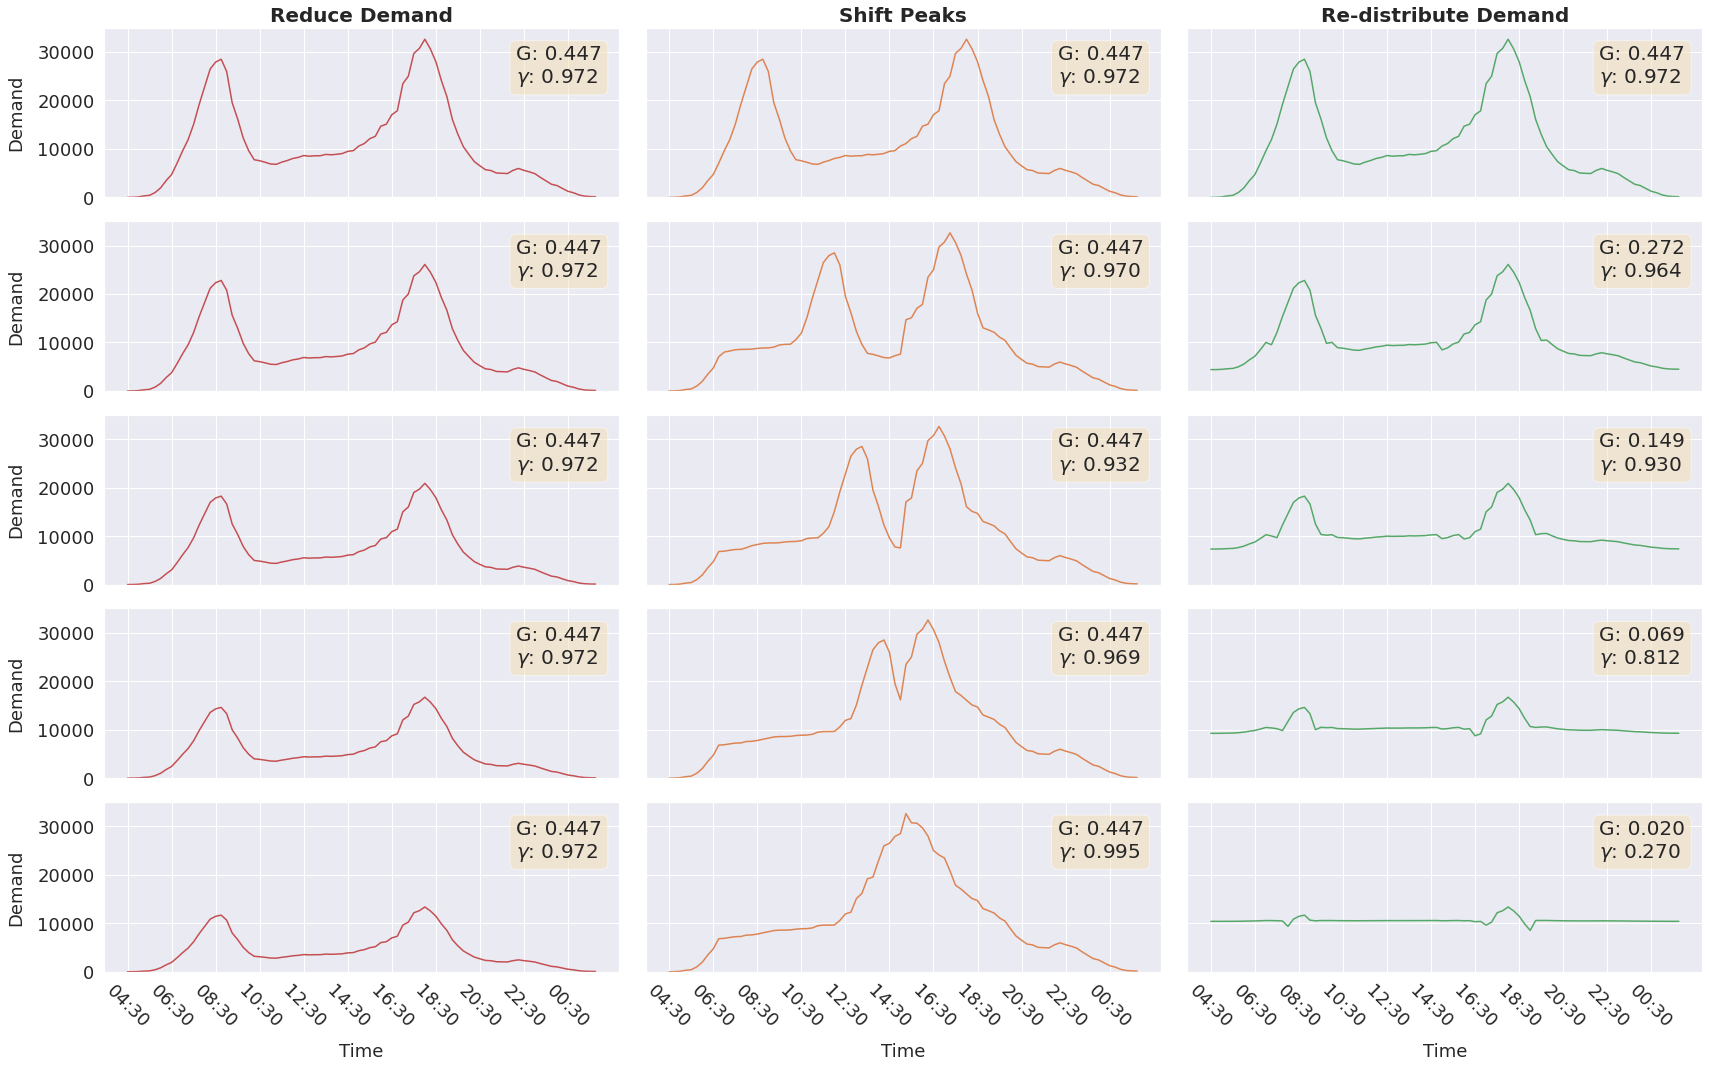

In [49]:
# Ignore runtime warning
warnings.simplefilter("ignore")

# Set parameters
n_times = 5
shift_dict = {0: [17, 55],
              1: [30, 52],
              2: [35, 50],
              3: [39, 48],
              4: [42, 44]}
titles = {0: "Reduce Demand",
          1: "Shift Peaks",
          2: "Re-distribute Demand"}

# Set up plot areas
fig, ax = plt.subplots(n_times, 3, figsize=(24,15),
                       sharex='col', sharey='row')

# First column
for i in range(n_times):
    
    # First column - reduce demand
    if i == 0:
        agg_ts_reduce = agg_ts_throughput.copy()
    else:
        agg_ts_reduce = reduce_demand(agg_ts_reduce, 0.20)
    # Plot
    plot_demand(demand=agg_ts_reduce, time_mapper=time_map_slot,
                n_nb=h, wt_mtd=wt_mtd,
                ax=ax[i, 0], color_plot=col_pal[3]);

    # Second column - shift peaks nearer
    if i == 0:
        agg_ts_shift = agg_ts_throughput.copy()
    else:
        agg_ts_shift = shift_peaks(agg_ts_throughput.copy(),
                                   shift_dict[0], shift_dict[i])
    # Plot
    plot_demand(demand=agg_ts_shift, time_mapper=time_map_slot,
                n_nb=h, wt_mtd=wt_mtd,
                ax=ax[i, 1], color_plot=col_pal[1]);

    # Third column - flatten peaks
    if i == 0:
        agg_ts_flatten = agg_ts_throughput.copy()
    else:
        agg_ts_flatten = flatten_peaks(agg_ts_flatten, 0.2)
    # Plot
    plot_demand(demand=agg_ts_flatten, time_mapper=time_map_slot,
                n_nb=h, wt_mtd=wt_mtd,
                ax=ax[i, 2], color_plot=col_pal[2]);

    # Formatting
    ax[i, 0].set_ylabel('Demand', size=18, labelpad=12)
    ax[i, 0].tick_params(axis='y', labelsize=18)

# Formatting
for j in range(3):
    ax[n_times-1, j].tick_params(axis='x', rotation=315, labelsize=18)
    ax[n_times-1, j].set_xlabel('Time', size=18, labelpad=12)
    ax[0, j].set_title(titles[j], size=20, weight="bold")

fig.tight_layout()

#fig.savefig('outputs/figures/measure_development/profile_change.png',
#            bbox_inches="tight")


# Reset warnings
warnings.resetwarnings()